In [1]:
# Import required libraries
import xarray as xr
from pathlib import Path
import numpy as np
import datetime
import pandas as pd
import cfgrib
import os
import shutil
from datetime import datetime
import matplotlib.pyplot as plt

## Creating the DWD Datacube

In [2]:
# Read the original datacube
ds_original = xr.open_dataset(Path.home() / 'hdd1/skondylatos/uc3/greece_big.nc')

In [3]:
ds_original

<xarray.Dataset>
Dimensions:                  (time: 4560, x: 1253, y: 983)
Coordinates:
  * time                     (time) datetime64[ns] 2009-03-06T10:00:00 ... 20...
  * x                        (x) float64 18.7 18.71 18.72 ... 28.88 28.89 28.9
  * y                        (y) float64 42.3 42.29 42.28 ... 34.32 34.31 34.3
    band                     int64 ...
    spatial_ref              int64 ...
Data variables: (12/90)
    1 km 16 days NDVI        (time, y, x) float32 ...
    1 km 16 days EVI         (time, y, x) float32 ...
    ET_500m                  (time, y, x) float32 ...
    LST_Day_1km              (time, y, x) float32 ...
    LST_Night_1km            (time, y, x) float32 ...
    Fpar_500m                (time, y, x) float32 ...
    ...                       ...
    population_density_2016  (y, x) float32 ...
    population_density_2017  (y, x) float32 ...
    population_density_2018  (y, x) float32 ...
    population_density_2019  (y, x) float32 ...
    population_density_2020  (y, x) float32 ...
    population_density_2021  (y, x) float32 ...
Attributes: (12/37)
    CDI:                        Climate Data Interface version 1.9.9rc1 (http...
    Conventions:                CF-1.6
    history:                    Mon Feb 07 16:26:09 2022: cdo mergetime greec...
    Source_Software:            dbinterface.py, dbexport.py, netcdf_handling.py
    creator_name:               Carolina Arias Munoz
    _CoordSysBuilder:           ucar.nc2.dataset.conv.CF1Convention
    ...                         ...
    License:                    Copernicus
    version:                    3.1
    NCO:                        netCDF Operators version 4.7.8 (Homepage = ht...
    cdo_openmp_thread_number:   8
    CDO:                        Climate Data Operators version 1.9.9rc1 (http...
    crs:                        EPSG:4326

In [4]:
def calculate_max(ds, time,stat):
    ds = ds.max(dim = 'time').expand_dims(time = time)
    # ds['time'] = ds['time'] + pd.Timedelta('1 days')
    ds = ds.rename({stat:'max_' + stat})
    return ds

def calculate_min(ds, time,stat):
    ds = ds.min(dim = 'time').expand_dims(time = time)
    # ds['time'] = ds['time'] + pd.Timedelta('1 days')
    ds = ds.rename({stat:'min_' + stat})
    return ds

def calculate_avg(ds, time,stat):
    ds = ds.mean(dim = 'time').expand_dims(time = time)
    # ds['time'] = ds['time'] + pd.Timedelta('1 days')
    ds = ds.rename({stat:'avg_' + stat})
    return ds

def calculate_wind_speed(ds):
    ds['wind_speed'] = np.sqrt(ds['u10'] ** 2 + ds['v10'] ** 2)
    return ds

In [5]:
#Fuction to create a dataset of a given meteo stat
def create_stat(stat):
    #List to store the datasets per day
    daily = []
    
    for i in range(193, 366):
        #List to store the datasets per hour
        dses = []
        
        for j in range(24, 36):
            #Path to the dataset
            path = 'jh-shared/uc3_service/2021_' + str(i) + '_1/' + str(stat) + '_' + str(j) + '.grib2'
            path = Path.home() / path
            tmp = xr.open_dataset(path, engine = 'cfgrib', indexpath = '')
            
            #Drop dimenesions we don't need
            if(stat == 'tp'):
                tmp = tmp.drop(['time', 'step', 'surface'])
            else:
                tmp = tmp.drop(['time', 'step', 'heightAboveGround'])
            time = tmp.valid_time.values
            tmp = tmp.expand_dims(time = [time])
            tmp = tmp.drop('valid_time')
            
            #Interpolate to lat and lon of the original dataset
            tmp = tmp.interp(longitude = ds_original.x.values, latitude = ds_original.y.values, method = 'nearest')
            
            #Add the dataset to the list
            dses.append(tmp)
            
        #Merge the datasets that are per hour to one for the day
        #We choose a random hour since we only care for the date
        time = dses[0].time.values
        if(stat == 'tp'):
            x = xr.merge(dses, compat='no_conflicts') 
            #From mm to m
            x = x / 1000
        else:
            x = xr.merge(dses, compat='no_conflicts')
        
        #We calculate the max,min and avg for the day
        x_max = calculate_max(x, time,stat)
        x_min = calculate_min(x, time,stat)
        x_avg = calculate_avg(x, time,stat)
        
        #Merge the stats we calculated to one dataset
        x = xr.merge([x_max, x_min, x_avg])
        
        #Add the dataset for the day to the list
        daily.append(x)
    
    #We merge all the datasets to one for the year 2021
    #We don't include the last two datasets cause they are predictions for the year 2022
    x = xr.merge([daily[0], daily[1]])
    for i in range(2,len(daily) - 1):
        x = xr.merge([x, daily[i]])
        
    return x

In [6]:
x_t2m = create_stat('t2m')

In [7]:
x_t2m

<xarray.Dataset>
Dimensions:    (time: 172, latitude: 983, longitude: 1253)
Coordinates:
  * time       (time) datetime64[ns] 2021-07-13T12:00:00 ... 2021-12-31T12:00:00
  * longitude  (longitude) float64 18.7 18.71 18.72 18.73 ... 28.88 28.89 28.9
  * latitude   (latitude) float64 42.3 42.29 42.28 42.27 ... 34.32 34.31 34.3
Data variables:
    max_t2m    (time, latitude, longitude) float32 300.9 300.9 ... 289.5 289.5
    min_t2m    (time, latitude, longitude) float32 298.7 298.7 ... 289.3 289.3
    avg_t2m    (time, latitude, longitude) float32 300.1 300.1 ... 289.4 289.4

In [8]:
x_tp = create_stat('tp')

In [9]:
x_tp

<xarray.Dataset>
Dimensions:    (time: 172, longitude: 1253, latitude: 983)
Coordinates:
  * time       (time) datetime64[ns] 2021-07-13T12:00:00 ... 2021-12-31T12:00:00
  * longitude  (longitude) float64 18.7 18.71 18.72 18.73 ... 28.88 28.89 28.9
  * latitude   (latitude) float64 42.3 42.29 42.28 42.27 ... 34.32 34.31 34.3
Data variables:
    max_tp     (time, latitude, longitude) float32 0.0 0.0 ... 0.01008 0.01008
    min_tp     (time, latitude, longitude) float32 0.0 0.0 ... 0.004812 0.004812
    avg_tp     (time, latitude, longitude) float32 0.0 0.0 ... 0.006915 0.006915

In [10]:
#List of datasets for every day
daily_u10 = []
daily_v10 = []
daily_wind_speed = []

#For every day
for i in range(193, 366):
    #List of datasets for different times of day
    dses_u10 = []
    dses_v_10 = []
    
    #For every time of day
    for j in range(24, 36):
        path_u10 = 'jh-shared/uc3_service/2021_' + str(i) + '_1/u10_' + str(j) + '.grib2'
        path_u10 = Path.home() / path_u10
        
        path_v_10 = 'jh-shared/uc3_service/2021_' + str(i) + '_1/v_10_' + str(j) + '.grib2'
        path_v_10 = Path.home() / path_v_10
        
        #Read the  girb file for the specific time
        tmp_u10 = xr.open_dataset(path_u10, engine = 'cfgrib', indexpath='')
        tmp_v_10 = xr.open_dataset(path_v_10, engine = 'cfgrib', indexpath='')
        
        
        #Drop dimensions
        tmp_u10 = tmp_u10.drop(['time', 'step', 'heightAboveGround'])
        tmp_v_10 = tmp_v_10.drop(['time', 'step', 'heightAboveGround'])
        
        #Add a time dimension
        time = tmp_u10.valid_time.values
        tmp_u10 = tmp_u10.expand_dims(time = [time])
        tmp_v_10 = tmp_v_10.expand_dims(time = [time])
        tmp_u10 = tmp_u10.drop('valid_time')
        tmp_v_10 = tmp_v_10.drop('valid_time')
        
        #Interpolate to the original datacube
        tmp_u10 = tmp_u10.interp(longitude = ds_original.x.values, latitude = ds_original.y.values, method = 'nearest')
        tmp_v_10 = tmp_v_10.interp(longitude = ds_original.x.values, latitude = ds_original.y.values, method = 'nearest')
        
        #Add the dataset to the list
        dses_u10.append(tmp_u10)
        dses_v_10.append(tmp_v_10)
        
        
    #Merge the datasets so we have one for the day
    x_u10 = xr.merge(dses_u10, compat='no_conflicts') 
    x_v10 = xr.merge(dses_v_10, compat='no_conflicts') 
    x_wind_speed = xr.merge([x_u10, x_v10])
    time = dses_u10[0].time.values
    
    #Calculate the required variables
    x_u10_max = calculate_max(x_u10, time, 'u10')
    x_u10_min = calculate_min(x_u10, time, 'u10')
    x_u10_avg = calculate_avg(x_u10, time, 'u10')
    
    x_v10_max = calculate_max(x_v10, time, 'v10')
    x_v10_min = calculate_min(x_v10, time, 'v10')
    x_v10_avg = calculate_avg(x_v10, time, 'v10')
    
    x_wind_speed = calculate_wind_speed(x_wind_speed)
    
    x_wind_speed_max = calculate_max(x_wind_speed, time, 'wind_speed')
    x_wind_speed_min = calculate_min(x_wind_speed, time, 'wind_speed')
    x_wind_speed_avg = calculate_avg(x_wind_speed, time, 'wind_speed')
    
    #Merge the datasets to one
    x_u10 = xr.merge([x_u10_max, x_u10_min, x_u10_avg])
    
    x_v10 = xr.merge([x_v10_max, x_v10_min, x_v10_avg])
    
    x_wind_speed_max = x_wind_speed_max.drop(['u10', 'v10'])
    x_wind_speed_min = x_wind_speed_min.drop(['u10', 'v10'])
    x_wind_speed_avg = x_wind_speed_avg.drop(['u10', 'v10'])
    
    x_wind_speed = xr.merge([x_wind_speed_max, x_wind_speed_min, x_wind_speed_avg])
    
    #Add the daily dataset to the list
    daily_u10.append(x_u10)
    daily_v10.append(x_v10)
    daily_wind_speed.append(x_wind_speed)
    
# Merge all the days to one dataset
x_u10 = xr.merge([daily_u10[0], daily_u10[1]])
x_v10 = xr.merge([daily_v10[0], daily_v10[1]])
x_wind_speed = xr.merge([daily_wind_speed[0], daily_wind_speed[1]])

#The last two datasets are predictions for 2022 so we don't include them
for i in range(2,len(daily_u10) - 1):
    x_u10 = xr.merge([x_u10, daily_u10[i]])
    x_v10 = xr.merge([x_v10, daily_v10[i]])
    x_wind_speed = xr.merge([x_wind_speed, daily_wind_speed[i]])

In [11]:
x_u10

<xarray.Dataset>
Dimensions:    (time: 172, latitude: 983, longitude: 1253)
Coordinates:
  * time       (time) datetime64[ns] 2021-07-13T12:00:00 ... 2021-12-31T12:00:00
  * longitude  (longitude) float64 18.7 18.71 18.72 18.73 ... 28.88 28.89 28.9
  * latitude   (latitude) float64 42.3 42.29 42.28 42.27 ... 34.32 34.31 34.3
Data variables:
    max_u10    (time, latitude, longitude) float32 0.3277 0.3277 ... -7.665
    min_u10    (time, latitude, longitude) float32 -1.724 -1.724 ... -9.586
    avg_u10    (time, latitude, longitude) float32 -0.5393 -0.5393 ... -9.098

In [12]:
x_v10

<xarray.Dataset>
Dimensions:    (time: 172, latitude: 983, longitude: 1253)
Coordinates:
  * time       (time) datetime64[ns] 2021-07-13T12:00:00 ... 2021-12-31T12:00:00
  * longitude  (longitude) float64 18.7 18.71 18.72 18.73 ... 28.88 28.89 28.9
  * latitude   (latitude) float64 42.3 42.29 42.28 42.27 ... 34.32 34.31 34.3
Data variables:
    max_v10    (time, latitude, longitude) float32 2.179 2.179 ... 1.227 1.227
    min_v10    (time, latitude, longitude) float32 0.3682 0.3682 ... -1.53 -1.53
    avg_v10    (time, latitude, longitude) float32 1.192 1.192 ... -0.5428

In [13]:
x_wind_speed

<xarray.Dataset>
Dimensions:         (time: 172, longitude: 1253, latitude: 983)
Coordinates:
  * time            (time) datetime64[ns] 2021-07-13T12:00:00 ... 2021-12-31T...
  * longitude       (longitude) float64 18.7 18.71 18.72 ... 28.88 28.89 28.9
  * latitude        (latitude) float64 42.3 42.29 42.28 ... 34.32 34.31 34.3
Data variables:
    max_wind_speed  (time, latitude, longitude) float32 2.499 2.499 ... 9.587
    min_wind_speed  (time, latitude, longitude) float32 0.6418 0.6418 ... 7.698
    avg_wind_speed  (time, latitude, longitude) float32 1.48 1.48 ... 9.146

In [14]:
final_cube = xr.merge([x_t2m, x_tp, x_u10, x_v10, x_wind_speed])

In [15]:
final_cube = final_cube.rename({'longitude' : 'x', 'latitude': 'y'})

In [16]:
final_cube

<xarray.Dataset>
Dimensions:         (time: 172, y: 983, x: 1253)
Coordinates:
  * time            (time) datetime64[ns] 2021-07-13T12:00:00 ... 2021-12-31T...
  * x               (x) float64 18.7 18.71 18.72 18.73 ... 28.88 28.89 28.9
  * y               (y) float64 42.3 42.29 42.28 42.27 ... 34.32 34.31 34.3
Data variables: (12/15)
    max_t2m         (time, y, x) float32 300.9 300.9 300.9 ... 289.5 289.5 289.5
    min_t2m         (time, y, x) float32 298.7 298.7 298.7 ... 289.3 289.3 289.3
    avg_t2m         (time, y, x) float32 300.1 300.1 300.1 ... 289.4 289.4 289.4
    max_tp          (time, y, x) float32 0.0 0.0 0.0 ... 0.01008 0.01008 0.01008
    min_tp          (time, y, x) float32 0.0 0.0 0.0 ... 0.004812 0.004812
    avg_tp          (time, y, x) float32 0.0 0.0 0.0 ... 0.006915 0.006915
    ...              ...
    max_v10         (time, y, x) float32 2.179 2.179 2.179 ... 1.227 1.227 1.227
    min_v10         (time, y, x) float32 0.3682 0.3682 0.3682 ... -1.53 -1.53
    avg_v10         (time, y, x) float32 1.192 1.192 1.192 ... -0.5428 -0.5428
    max_wind_speed  (time, y, x) float32 2.499 2.499 2.499 ... 9.587 9.587 9.587
    min_wind_speed  (time, y, x) float32 0.6418 0.6418 0.6418 ... 7.698 7.698
    avg_wind_speed  (time, y, x) float32 1.48 1.48 1.48 ... 9.146 9.146 9.146

In [19]:
#Save the Datacube to a file
path = Path.home() / 'hdd1/diogenis/observatory/dwd_meteo.nc'
final_cube.to_netcdf(path)

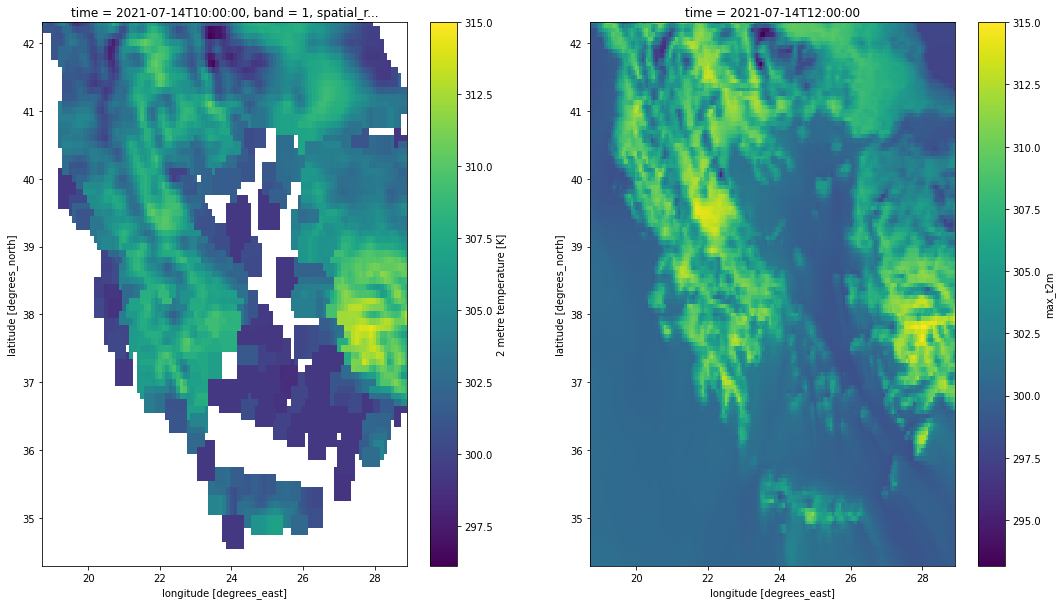

In [20]:
#Qualitative comparison by ploting
fig, axes = plt.subplots(ncols=2, figsize = (18,10))
ds_original.sel(time = '2021-07-14').era5_max_t2m.plot(ax=axes[0], vmax = 315)
final_cube.sel(time = '2021-07-14').max_t2m.plot(ax=axes[1] , vmax = 315)

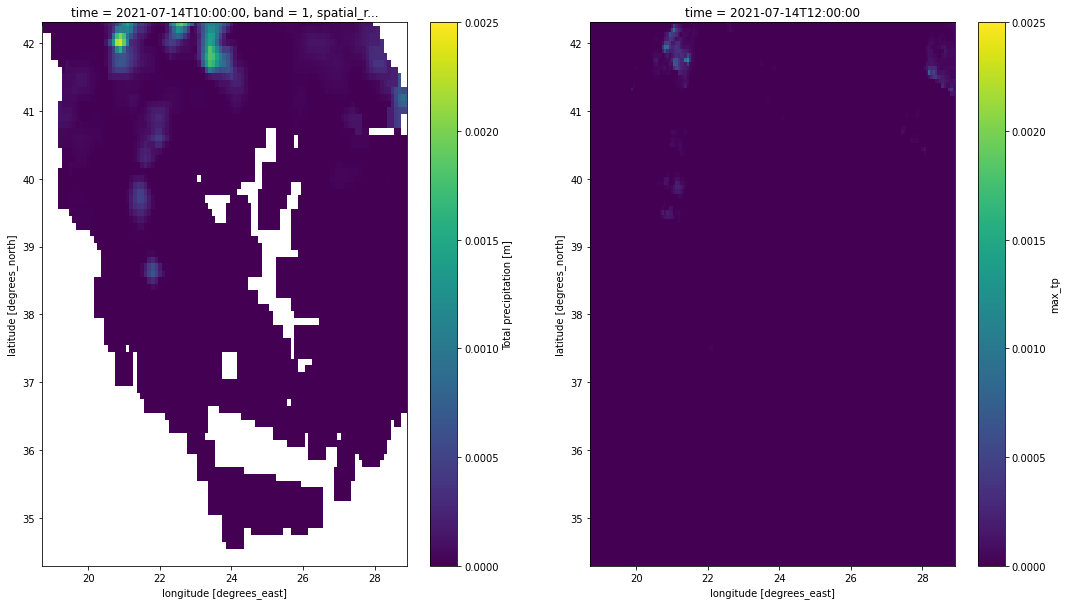

In [21]:
fig, axes = plt.subplots(ncols=2, figsize = (18,10))
ds_original.sel(time = '2021-07-14').era5_max_tp.plot(ax=axes[0], vmax = 0.0025)
final_cube.sel(time = '2021-07-14').max_tp.plot(ax=axes[1], vmax = 0.0025)

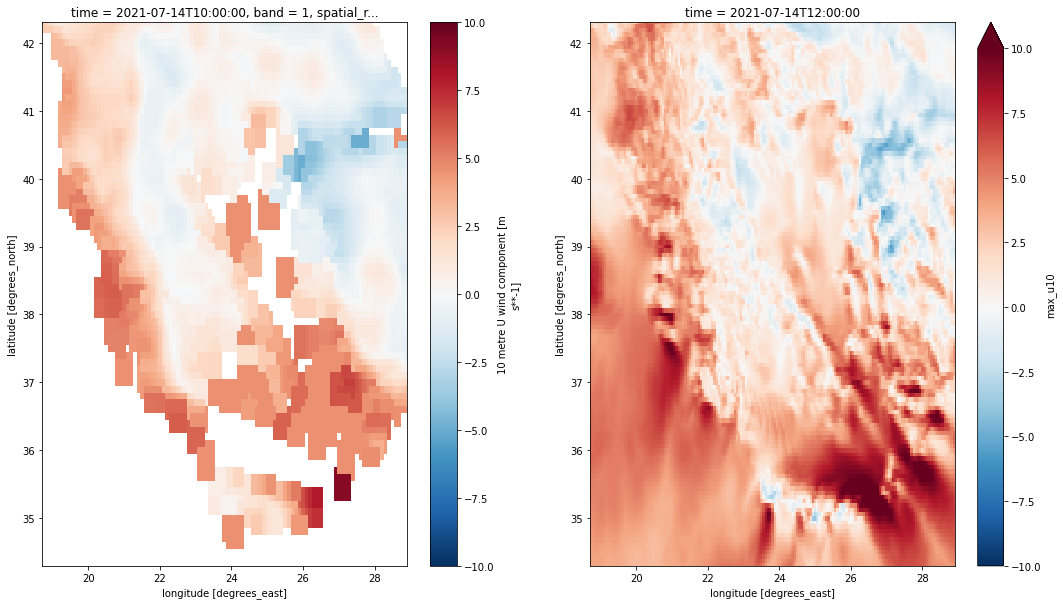

In [22]:
fig, axes = plt.subplots(ncols=2, figsize = (18,10))
ds_original.sel(time = '2021-07-14').era5_max_u10.plot(ax=axes[0], vmax = 10)
final_cube.sel(time = '2021-07-14').max_u10.plot(ax=axes[1], vmax = 10)

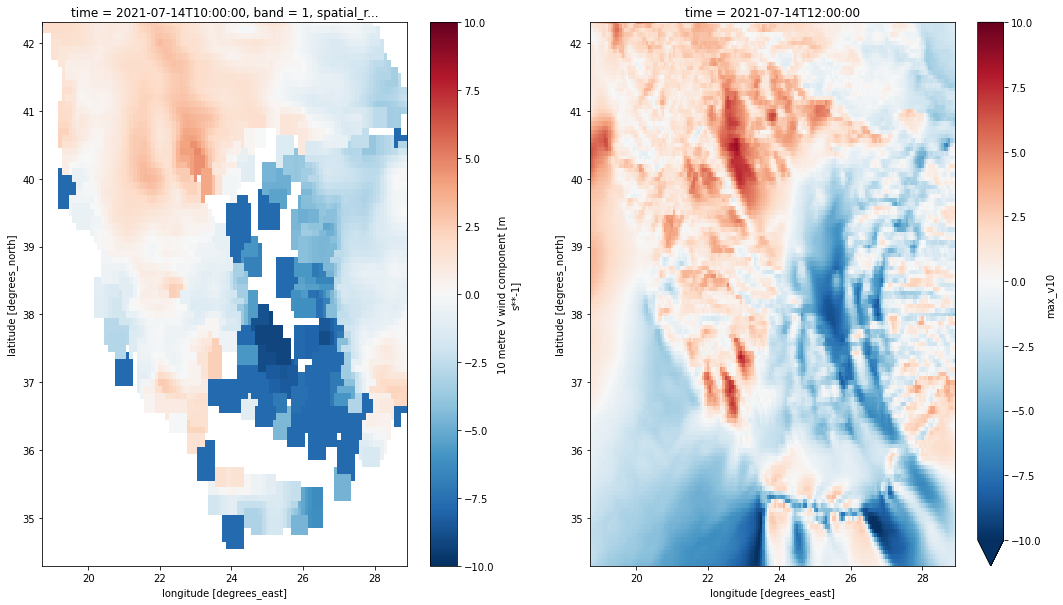

In [23]:
fig, axes = plt.subplots(ncols=2, figsize = (18,10))
ds_original.sel(time = '2021-07-14').era5_max_v10.plot(ax=axes[0], vmax = 10)
final_cube.sel(time = '2021-07-14').max_v10.plot(ax=axes[1], vmax = 10)

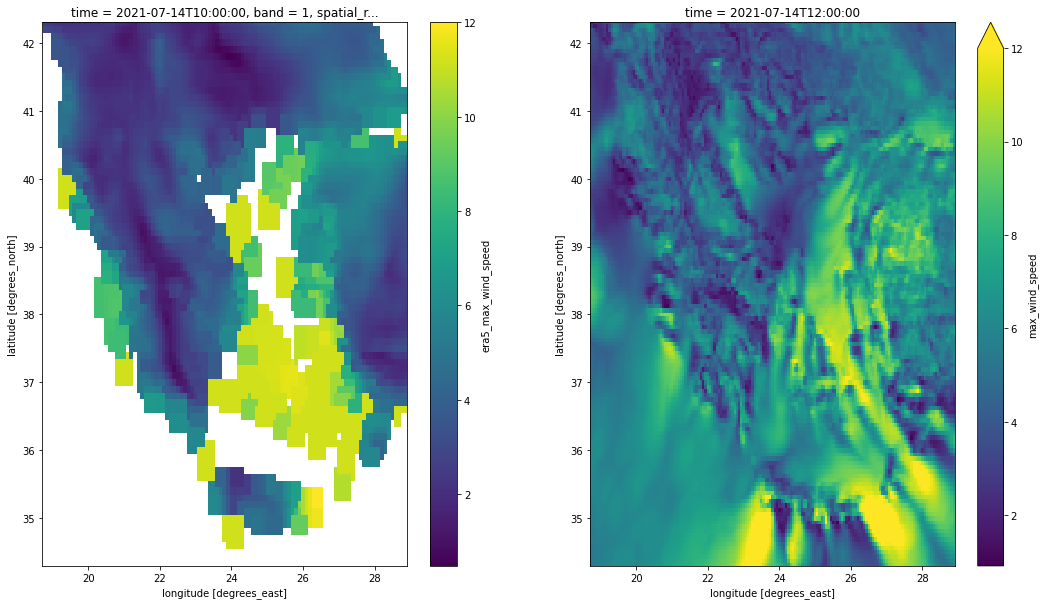

In [24]:
fig, axes = plt.subplots(ncols=2, figsize = (18,10))
ds_original.sel(time = '2021-07-14').era5_max_wind_speed.plot(ax=axes[0], vmax = 12)
final_cube.sel(time = '2021-07-14').max_wind_speed.plot(ax=axes[1], vmax = 12)

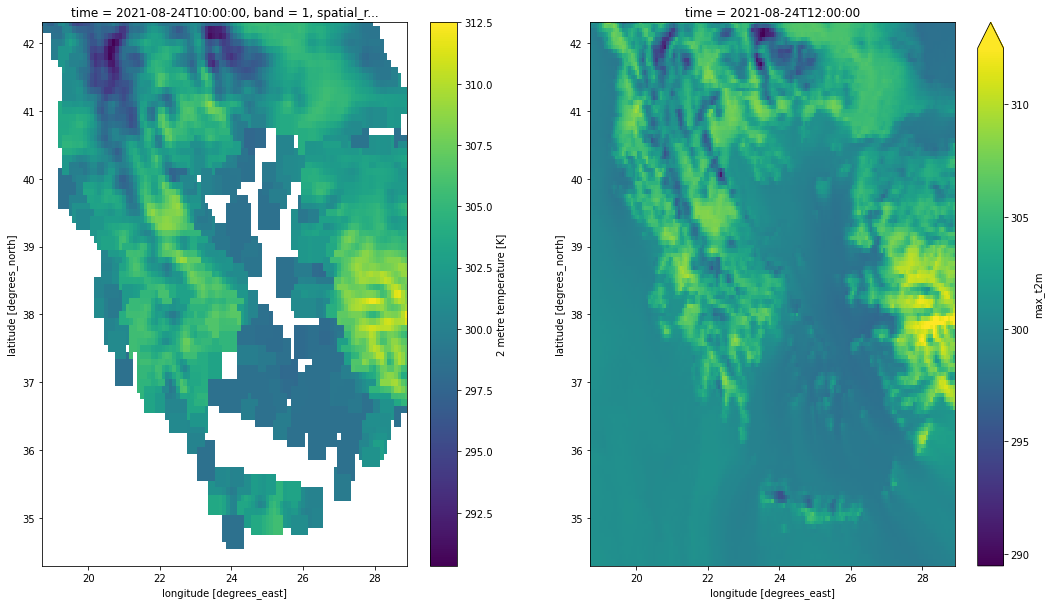

In [25]:
fig, axes = plt.subplots(ncols=2, figsize = (18,10))
ds_original.sel(time = '2021-08-24').era5_max_t2m.plot(ax=axes[0], vmax = 312.5)
final_cube.sel(time = '2021-08-24').max_t2m.plot(ax=axes[1], vmax = 312.5)

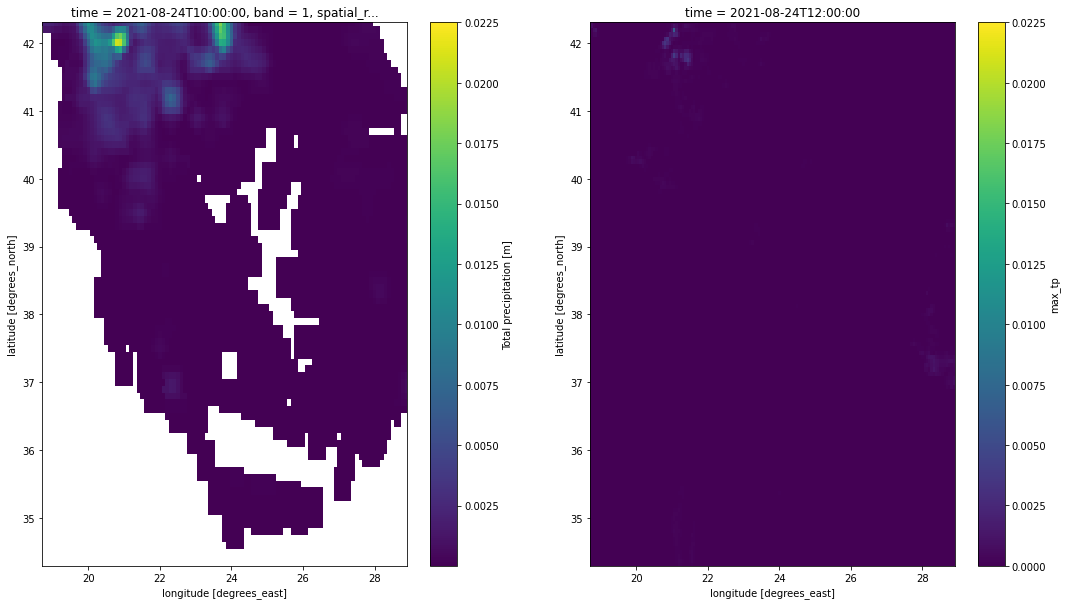

In [26]:
fig, axes = plt.subplots(ncols=2, figsize = (18,10))
ds_original.sel(time = '2021-08-24').era5_max_tp.plot(ax=axes[0], vmax = 0.0225)
final_cube.sel(time = '2021-08-24').max_tp.plot(ax=axes[1], vmax = 0.0225)

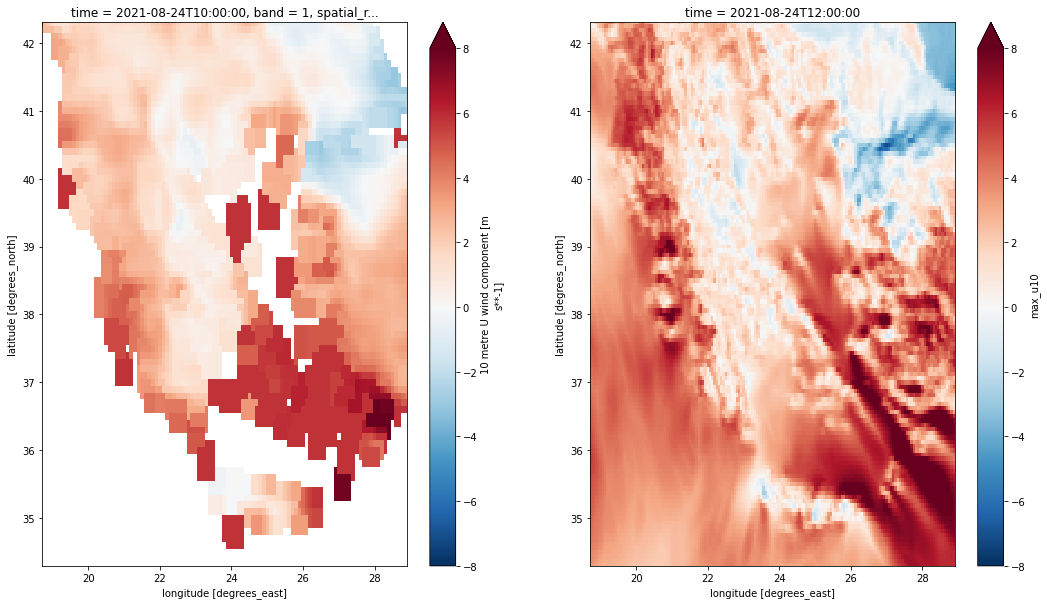

In [27]:
fig, axes = plt.subplots(ncols=2, figsize = (18,10))
ds_original.sel(time = '2021-08-24').era5_max_u10.plot(ax=axes[0], vmax = 8)
final_cube.sel(time = '2021-08-24').max_u10.plot(ax=axes[1], vmax = 8)

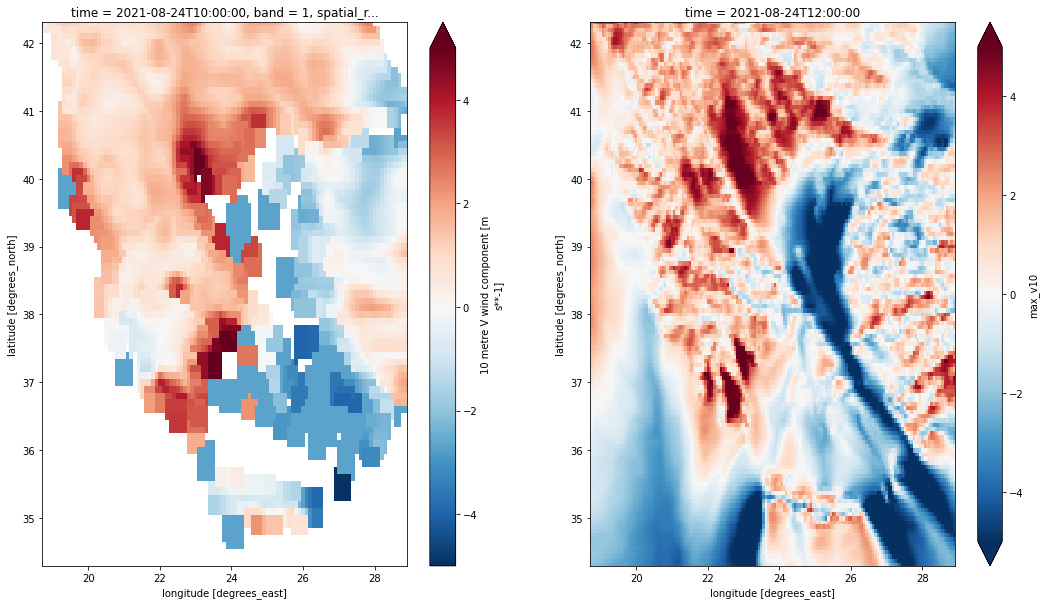

In [28]:
fig, axes = plt.subplots(ncols=2, figsize = (18,10))
ds_original.sel(time = '2021-08-24').era5_max_v10.plot(ax=axes[0], vmax = 5)
final_cube.sel(time = '2021-08-24').max_v10.plot(ax=axes[1], vmax = 5)

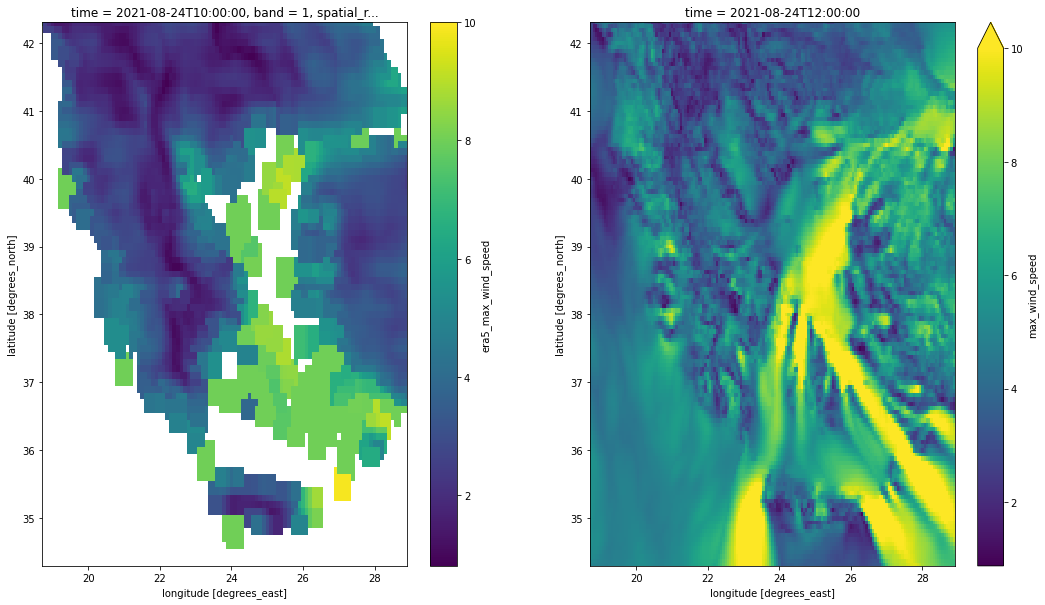

In [29]:
fig, axes = plt.subplots(ncols=2, figsize = (18,10))
ds_original.sel(time = '2021-08-24').era5_max_wind_speed.plot(ax=axes[0], vmax = 10)
final_cube.sel(time = '2021-08-24').max_wind_speed.plot(ax=axes[1], vmax = 10)